In [1]:
#default_exp clean

# Data Cleaning

<br>

### Imports

In [2]:
#exports
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import os
import glob
from ipypb import track

from batopt import utils, retrieval

In [3]:
from IPython.display import JSON

<br>

### User Inputs

In [4]:
raw_data_dir = '../data/raw'
cache_data_dir = '../data/nb-cache'

<br>

### Loading the Raw Data

We'll start by loading in the demand data, first we have to determine the latest training set that is available for us to work with

In [5]:
#exports
def identify_latest_set_num(data_dir):
    set_num = max([
        int(f.split('_set')[1].replace('.csv', '')) 
        for f in os.listdir(data_dir) 
        if 'set' in f
    ])
    
    return set_num

In [6]:
set_num = identify_latest_set_num(raw_data_dir)

set_num

1

<br>

We'll then load in and clean the datetime index of the dataset

In [7]:
#exports
def reindex_df_dt_idx(df, freq='30T'):
    full_dt_idx = pd.date_range(df.index.min(), df.index.max(), freq=freq)
    df = df.reindex(full_dt_idx)
    
    return df

def load_training_dataset(raw_data_dir: str, dataset_name: str='demand', set_num=None, parse_dt_idx: bool=True, dt_idx_freq: str='30T') -> pd.DataFrame:
    if set_num is None:
        set_num = identify_latest_set_num(raw_data_dir)
        
    allowed_datasets = ['demand', 'pv', 'weather']
    assert dataset_name in allowed_datasets, f"`dataset_name` must be one of: {', '.join(allowed_datasets)} - not {dataset_name}"
    
    df = pd.read_csv(glob.glob(f'{raw_data_dir}/{dataset_name}*set{set_num}.csv')[0].replace('\\', '/'))
    
    if parse_dt_idx == True:
        assert 'datetime' in df.columns, 'if `parse_dt_idx` is True then `datetime` must be a column in the dataset'
        
        df['datetime'] = pd.to_datetime(df['datetime'], utc=True)
        df = df.set_index('datetime').pipe(reindex_df_dt_idx, freq=dt_idx_freq).sort_index(axis=1)
        df.index.name = 'datetime'

    return df

In [8]:
df_demand = load_training_dataset(raw_data_dir, 'demand')

df_demand.head()

,demand_MW
datetime,
2017-11-03 00:00:00+00:00,2.19
2017-11-03 00:30:00+00:00,2.14
2017-11-03 01:00:00+00:00,2.01
2017-11-03 01:30:00+00:00,1.87
2017-11-03 02:00:00+00:00,1.86


<br>

Then the pv

In [9]:
df_pv = load_training_dataset(raw_data_dir, 'pv')

df_pv.head()

,irradiance_Wm-2,panel_temp_C,pv_power_mw
datetime,,,
2017-11-03 00:00:00+00:00,0.0,7.05,0.0
2017-11-03 00:30:00+00:00,0.0,7.38,0.0
2017-11-03 01:00:00+00:00,0.0,7.70,0.0
2017-11-03 01:30:00+00:00,0.0,7.48,0.0
2017-11-03 02:00:00+00:00,0.0,7.20,0.0


<br>

And finally the weather

In [10]:
df_weather = load_training_dataset(raw_data_dir, 'weather', dt_idx_freq='H')

df_weather.head(3)

,solar_location1,solar_location2,solar_location3,solar_location4,solar_location5,solar_location6,temp_location1,temp_location2,temp_location3,temp_location4,temp_location5,temp_location6
datetime,,,,,,,,,,,,
2015-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,9.75,9.65,8.83,7.58,11.62,11.22
2015-01-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,9.91,9.76,8.90,7.62,11.65,11.32
2015-01-01 02:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,9.99,9.80,9.10,7.61,11.65,11.30


<br>

We'll also create a function that reads all of the datasets in at once and then combines them

In [11]:
#exports
def combine_training_datasets(raw_data_dir, set_num=None):
    # Loading provided training datasets
    single_datasets = dict()
    dataset_names = ['demand', 'pv', 'weather']

    for dataset_name in dataset_names:
        single_datasets[dataset_name] = load_training_dataset(raw_data_dir, dataset_name, set_num=set_num)
    
    # Constructing date range
    min_dt = min([df.index.min() for df in single_datasets.values()])
    max_dt = max([df.index.max() for df in single_datasets.values()]) + pd.Timedelta(minutes=30)

    dt_rng = pd.date_range(min_dt, max_dt, freq='30T')
    
    # Constructing combined dataframe
    df_combined = pd.DataFrame(index=dt_rng, columns=dataset_names)
    
    for dataset_name in dataset_names:
        df_single_dataset = single_datasets[dataset_name]
        cols_to_be_overwritten = set(df_combined.columns) - (set(df_combined.columns) - set(df_single_dataset.columns))
        assert len(cols_to_be_overwritten) == 0, f"The following columns exist in multiple datasets meaning data would be overwritten: {', '.join(cols_to_be_overwritten)}"

        df_combined[df_single_dataset.columns] = df_single_dataset
    
    df_combined = df_combined.sort_index()
    
    # Adding holiday dates
    s_holidays = retrieval.load_holidays_s(raw_data_dir)
    
    s_cropped_holidays = s_holidays[max(df_combined.index.min(), s_holidays.index.min()):
                                    min(df_combined.index.max(), s_holidays.index.max())]
    
    df_combined.loc[s_cropped_holidays.index, 'holidays'] = s_cropped_holidays
    
    return df_combined

In [12]:
df_combined = combine_training_datasets(raw_data_dir)

df_combined.head(3)

,demand,pv,weather,demand_MW,irradiance_Wm-2,panel_temp_C,pv_power_mw,solar_location1,solar_location2,solar_location3,solar_location4,solar_location5,solar_location6,temp_location1,temp_location2,temp_location3,temp_location4,temp_location5,temp_location6,holidays
2015-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,9.75,9.65,8.83,7.58,11.62,11.22,NaN
2015-01-01 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,9.91,9.76,8.90,7.62,11.65,11.32,NaN



<br>

### Identifying Missing Values

We'll quickly inspect the datasets and check their coverage over the full date range when aggregated by dataset

In [13]:
#exports
def identify_df_dt_entries(df_demand, df_pv, df_weather):
    min_dt = min(df_demand.index.min(), df_pv.index.min(), df_weather.index.min())
    max_dt = max(df_demand.index.max(), df_pv.index.max(), df_weather.index.max())
    
    dt_rng = pd.date_range(min_dt, max_dt, freq='30T')
    df_nulls = pd.DataFrame(index=dt_rng)
    
    df_nulls['demand'] = df_demand.reindex(dt_rng).isnull().mean(axis=1).astype(int)
    df_nulls['pv'] = df_pv.reindex(dt_rng).isnull().mean(axis=1).astype(int)
    df_nulls['weather'] = df_weather.reindex(dt_rng).ffill(limit=1).isnull().mean(axis=1).astype(int)
    
    df_entries = 1 - df_nulls
    
    return df_entries

<AxesSubplot:>

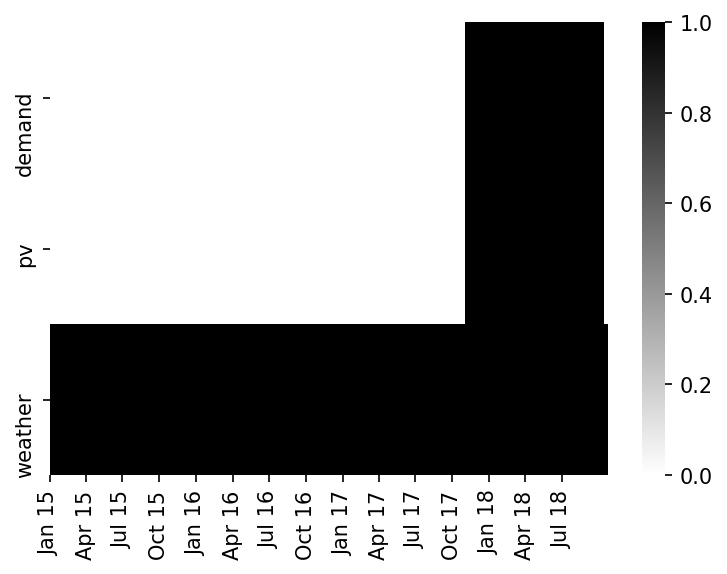

In [14]:
df_entries = identify_df_dt_entries(df_demand, df_pv, df_weather)

# Plotting
fig, ax = plt.subplots(dpi=150)

sns.heatmap(df_entries.T, ax=ax, cmap=plt.cm.binary)

utils.set_date_ticks(ax, '2015-01-01', '2018-07-31', axis='x', freq='Qs', date_format='%b %y')

<br>

We'll also determine the null percentage in each individual column

In [15]:
df_demand.isnull().mean()

demand_MW    0.0
dtype: float64

<br>

We can see that all of the PV data columns are missing some data

In [16]:
df_pv.isnull().mean()

irradiance_Wm-2    0.001201
panel_temp_C       0.004323
pv_power_mw        0.001201
dtype: float64

<br>

Location 2 is also missing some solar data

In [17]:
df_weather.isnull().mean()

solar_location1    0.000000
solar_location2    0.000719
solar_location3    0.000000
solar_location4    0.000000
solar_location5    0.000000
solar_location6    0.000000
temp_location1     0.000000
temp_location2     0.000000
temp_location3     0.000000
temp_location4     0.000000
temp_location5     0.000000
temp_location6     0.000000
dtype: float64

In [18]:
# !!! We also need to handle the two days where demand is constantly 0 !!!
# Separately it looks like there's also some anomalous 0 readings for the PV output

In [19]:
(df_demand==0).sum()

demand_MW    58
dtype: int64

In [20]:
df_demand.query('demand_MW==0').head()

,demand_MW
datetime,
2018-05-08 08:00:00+00:00,0.0
2018-05-08 08:30:00+00:00,0.0
2018-05-08 09:00:00+00:00,0.0
2018-05-08 09:30:00+00:00,0.0
2018-05-08 10:00:00+00:00,0.0


<br>

### Handling Missing Values

We'll start by interpolating the missing PV data, first checking the number of variables that have null values for each time period

In [21]:
s_pv_num_null_vals = df_pv.isnull().sum(axis=1).replace(0, np.nan).dropna().astype(int)

s_pv_num_null_vals.value_counts()

1    52
3    20
dtype: int64

<br>

`pv_power_mw` and `irradiance_Wm-2` have the same average number of null values, there are also no time-periods where only 2 variables have null values - it's therefore likely that power and irradiance always have null periods at the same time which makes it harder to interpolate their values. We'll quickly check this hypothesis:

In [22]:
(df_pv['pv_power_mw'].isnull() == df_pv['irradiance_Wm-2'].isnull()).mean() == 1

True

<br>

It appears as though the `pv_power_mw` and `irradiance_Wm-2` missing values are a single time-block that coincides with a larger set of missing values within `panel_temp_C`.

In [23]:
df_pv[df_pv['pv_power_mw'].isnull()]

,irradiance_Wm-2,panel_temp_C,pv_power_mw
datetime,,,
2018-03-04 07:00:00+00:00,NaN,NaN,NaN
2018-03-04 07:30:00+00:00,NaN,NaN,NaN
2018-03-04 08:00:00+00:00,NaN,NaN,NaN
2018-03-04 08:30:00+00:00,NaN,NaN,NaN
2018-03-04 09:00:00+00:00,NaN,NaN,NaN
2018-03-04 09:30:00+00:00,NaN,NaN,NaN
2018-03-04 10:00:00+00:00,NaN,NaN,NaN
2018-03-04 10:30:00+00:00,NaN,NaN,NaN
2018-03-04 11:00:00+00:00,NaN,NaN,NaN


<br>

Looking at the `panel_temp_C` data we can see there are 3 time-blocks where obervations are missing 

<AxesSubplot:xlabel='datetime'>

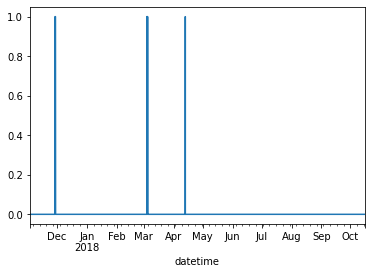

In [24]:
df_pv['panel_temp_C'].isnull().astype(int).plot()

<br>

One option might to be replace the missing temperature values with the temperatures observed at the surrounding weather grid locations, we'll start by constructing a dataframe that includes all of the temperature data as well as the average rolling temperature for each weather data location.

In [25]:
#exports
def construct_df_temp_features(df_weather, df_pv):
    df_weather = df_weather.reindex(pd.date_range(df_weather.index.min(), df_weather.index.max(), freq='30T')).ffill(limit=1)
    temp_loc_cols = df_weather.columns[df_weather.columns.str.contains('temp')]
    
    df_temp_features = (df_weather
                        .copy()
                        [temp_loc_cols]
                        .assign(site_temp=df_pv['panel_temp_C'])
                       )

    df_temp_features[[col+'_rolling' for col in temp_loc_cols]] = df_temp_features.rolling(3).mean()[temp_loc_cols]

    df_temp_features = df_temp_features.sort_index(axis=1)

    return df_temp_features

In [26]:
df_temp_features = construct_df_temp_features(df_weather, df_pv).dropna()

df_temp_features.head()

,site_temp,temp_location1,temp_location1_rolling,temp_location2,temp_location2_rolling,temp_location3,temp_location3_rolling,temp_location4,temp_location4_rolling,temp_location5,temp_location5_rolling,temp_location6,temp_location6_rolling
2017-11-03 00:00:00+00:00,7.05,8.56,8.626667,9.64,9.660000,7.46,7.786667,6.68,6.933333,13.09,13.023333,13.20,13.113333
2017-11-03 00:30:00+00:00,7.38,8.56,8.593333,9.64,9.650000,7.46,7.623333,6.68,6.806667,13.09,13.056667,13.20,13.156667
2017-11-03 01:00:00+00:00,7.70,8.69,8.603333,9.71,9.663333,7.14,7.353333,6.27,6.543333,13.21,13.130000,13.32,13.240000
2017-11-03 01:30:00+00:00,7.48,8.69,8.646667,9.71,9.686667,7.14,7.246667,6.27,6.406667,13.21,13.170000,13.32,13.280000
2017-11-03 02:00:00+00:00,7.20,8.74,8.706667,9.73,9.716667,6.86,7.046667,5.91,6.150000,13.30,13.240000,13.36,13.333333


<br>

We'll now check the correlation

<AxesSubplot:>

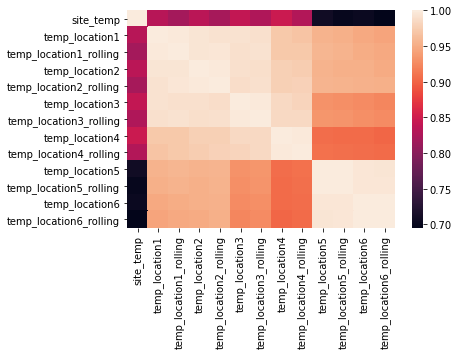

In [27]:
sns.heatmap(df_temp_features.corr())

<br>

The correlation drops off quickly when it gets to the site temperature, looking at the full distributions we can see that the site measurements get far higher. This is because the panel is absorbing heat that raises its temperature above that of the surrounding area, again making it more difficult to simply fill in with the nearby temperature measurements.

C:\Users\Ayrto\anaconda3\envs\batopt\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Ayrto\anaconda3\envs\batopt\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Ayrto\anaconda3\envs\batopt\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

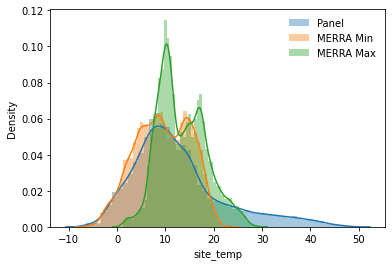

In [28]:
sns.distplot(df_temp_features['site_temp'], color='C0', label='Panel')
sns.distplot(df_temp_features.drop('site_temp', axis=1).min(axis=1), color='C1', label='MERRA Min')
sns.distplot(df_temp_features.drop('site_temp', axis=1).max(axis=1), color='C2', label='MERRA Max')

plt.legend(frameon=False)

In [29]:
# Could use an RF to estimate the panel temp based on the weather grid temps?
# Potential features: current average surrounding temp, average surrounding temp over the last 3 hours

In [30]:
#exports
def split_X_y_data(df, target_col='site_temp'):
    df = df.dropna()
    X_cols = df.drop(target_col, axis=1).columns

    X = df[X_cols].values
    y = df[target_col].values
    
    return X, y

def split_X_y_data_with_index(df, target_col='site_temp'):
    df = df.dropna()
    X_cols = df.drop(target_col, axis=1).columns

    X = df[X_cols].values
    y = df[target_col].values
    index = df.index
    
    return X, y, index

In [31]:
X, y = split_X_y_data(df_temp_features)

X.shape, y.shape

((16584, 12), (16584,))

In [32]:
#exports
def generate_kfold_preds(
    X, 
    y, 
    model=LinearRegression(), 
    kfold_kwargs={'n_splits': 5, 'shuffle': True},
    index=None
):

    kfold = KFold(**kfold_kwargs)
    df_pred = pd.DataFrame(columns=['pred', 'true'], index=np.arange(X.shape[0]))

    for train_idxs, test_idxs in kfold.split(X):
        X_train, y_train = X[train_idxs], y[train_idxs]
        X_test, y_test = X[test_idxs], y[test_idxs]
    
        model.fit(X_train, y_train)
        
        df_pred.loc[test_idxs, 'true'] = y_test
        df_pred.loc[test_idxs, 'pred'] = model.predict(X_test)
        
    df_pred = df_pred.sort_index()
    
    if index is not None:
        assert len(index) == df_pred.shape[0], 'The passed index must be the same length as X and y'
        df_pred.index = index
        
    return df_pred

In [33]:
df_pred = generate_kfold_preds(X, y)

df_pred.head()

,pred,true
0,4.796152,7.05
1,5.058114,7.38
2,5.573718,7.70
3,5.607939,7.48
4,5.419194,7.20


In [34]:
#exports
def evaluate_models(X, y, models, post_pred_proc_func=None, index=None):
    model_scores = dict()

    for model_name, model in track(models.items()):
        df_pred = generate_kfold_preds(X, y, model, index=index)
        
        if post_pred_proc_func is not None:
            df_pred['pred'] = post_pred_proc_func(df_pred['pred'])

        model_scores[model_name] = {
            'mae': mean_absolute_error(df_pred['true'], df_pred['pred']),
            'rmse': np.sqrt(mean_squared_error(df_pred['true'], df_pred['pred']))
        }

    df_model_scores = pd.DataFrame(model_scores)
    
    df_model_scores.index.name = 'metric'
    df_model_scores.columns.name = 'model'

    return df_model_scores

In [35]:
models = {
    'std_linear': LinearRegression(),
    'random_forest': RandomForestRegressor(),
    'boosted': GradientBoostingRegressor()
}

rerun_panel_temp_model = False
model_scores_filename = 'panel_temp_interp_model_results.csv'

if (rerun_panel_temp_model == True) or (model_scores_filename not in os.listdir(cache_data_dir)):
    df_model_scores = evaluate_models(X, y, models)
    df_model_scores.to_csv(f'{cache_data_dir}/{model_scores_filename}')
else:
    df_model_scores = pd.read_csv(f'{cache_data_dir}/{model_scores_filename}', index_col='metric')

df_model_scores

,std_linear,random_forest,boosted
metric,,,
mae,2.819220,1.684513,2.581428
rmse,3.786736,2.693341,3.734153


In [36]:
top_model = df_model_scores.T['rmse'].idxmin()
df_pred = generate_kfold_preds(X, y, models[top_model])

df_pred.head()

,pred,true
0,7.1093,7.05
1,6.8888,7.38
2,7.2142,7.70
3,7.2276,7.48
4,6.9483,7.20


<AxesSubplot:>

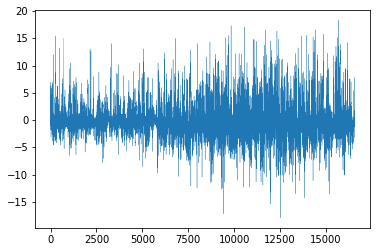

In [37]:
s_residuals = df_pred.diff(1, axis=1).dropna(axis=1).iloc[:, 0]

s_residuals.plot(linewidth=0.3)

Text(0, 0.5, 'Prediction')

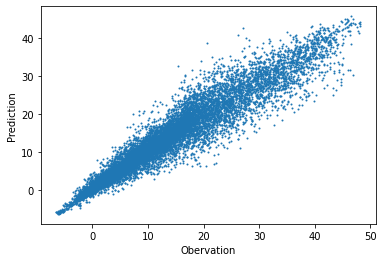

In [38]:
plt.scatter(df_pred['true'], df_pred['pred'], s=1)

plt.xlabel('Obervation')
plt.ylabel('Prediction')

In [39]:
#exports
def interpolate_missing_panel_temps(df_pv, df_weather, model=RandomForestRegressor()):
    missing_panel_temp_dts = df_pv.index[df_pv['panel_temp_C'].isnull()]
    
    if len(missing_panel_temp_dts) == 0: # i.e. no missing values
        return df_pv

    df_temp_features = construct_df_temp_features(df_weather, df_pv)
    missing_dt_X = df_temp_features.loc[missing_panel_temp_dts].drop('site_temp', axis=1).values
    X, y = split_X_y_data(df_temp_features, 'site_temp')
    
    model.fit(X, y)
    df_pv.loc[missing_panel_temp_dts, 'panel_temp_C'] = model.predict(missing_dt_X)
    
    assert df_pv['panel_temp_C'].isnull().sum() == 0, 'There are still null values for the PV panel temperature'
    
    return df_pv

In [40]:
df_pv = interpolate_missing_panel_temps(df_pv, df_weather)

df_pv.isnull().mean()

irradiance_Wm-2    0.001201
panel_temp_C       0.000000
pv_power_mw        0.001201
dtype: float64

In [41]:
#exports
def construct_df_irradiance_features(df_weather, df_pv):
    df_weather = df_weather.reindex(pd.date_range(df_weather.index.min(), df_weather.index.max(), freq='30T')).ffill(limit=1)
    temp_loc_cols = df_weather.columns[df_weather.columns.str.contains('solar')]
    
    df_irradiance_features = (df_weather
                              .copy()
                              [temp_loc_cols]
                              .assign(site_solar=df_pv['irradiance_Wm-2'])
                              .pipe(lambda df: df.assign(hour=df.index.hour + df.index.minute/60))
                             )

    df_irradiance_features = df_irradiance_features.sort_index(axis=1)

    return df_irradiance_features

In [42]:
df_irradiance_features = construct_df_irradiance_features(df_weather, df_pv)

df_irradiance_features.head()

,hour,site_solar,solar_location1,solar_location2,solar_location3,solar_location4,solar_location5,solar_location6
2015-01-01 00:00:00+00:00,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 00:30:00+00:00,0.5,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 01:00:00+00:00,1.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 01:30:00+00:00,1.5,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2015-01-01 02:00:00+00:00,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
models = {
    'std_linear': LinearRegression(),
    'random_forest': RandomForestRegressor(),
    'boosted': GradientBoostingRegressor()
}

rerun_site_irradiance_model = False
model_scores_filename = 'site_irradiance_interp_model_results.csv'

X, y = split_X_y_data(df_irradiance_features, 'site_solar')

if (rerun_site_irradiance_model == True) or (model_scores_filename not in os.listdir(cache_data_dir)):
    df_model_scores = evaluate_models(X, y, models)
    df_model_scores.to_csv(f'{cache_data_dir}/{model_scores_filename}')
else:
    df_model_scores = pd.read_csv(f'{cache_data_dir}/{model_scores_filename}', index_col='metric')

df_model_scores

,std_linear,random_forest,boosted
metric,,,
mae,57.497688,37.508653,49.695589
rmse,110.546061,78.852450,99.196357


In [44]:
top_model = df_model_scores.T['rmse'].idxmin()
df_pred = generate_kfold_preds(X, y, models[top_model])

df_pred.head()

,pred,true
0,0.000000,0.0
1,0.000000,0.0
2,0.000000,0.0
3,0.000124,0.0
4,0.000000,0.0


Text(0, 0.5, 'Prediction')

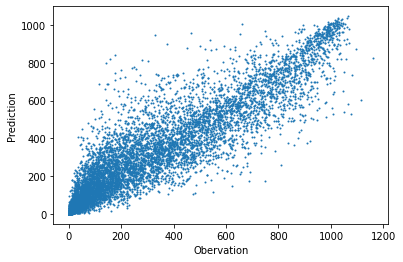

In [45]:
plt.scatter(df_pred['true'], df_pred['pred'], s=1)

plt.xlabel('Obervation')
plt.ylabel('Prediction')

In [46]:
#exports
def interpolate_missing_site_irradiance(df_pv, df_weather, model=RandomForestRegressor()):
    missing_site_irradiance_dts = df_pv.index[df_pv['irradiance_Wm-2'].isnull()]
    
    if len(missing_site_irradiance_dts) == 0: # i.e. no missing values
        return df_pv

    df_irradiance_features = construct_df_irradiance_features(df_weather, df_pv)
    missing_dt_X = df_irradiance_features.loc[missing_site_irradiance_dts].drop('site_solar', axis=1).values
    X, y = split_X_y_data(df_irradiance_features, 'site_solar')
 
    model.fit(X, y)
    df_pv.loc[missing_site_irradiance_dts, 'irradiance_Wm-2'] = model.predict(missing_dt_X)
    
    assert df_pv['irradiance_Wm-2'].isnull().sum() == 0, 'There are still null values for the solar site irradiance'
    
    return df_pv

In [47]:
df_pv = interpolate_missing_site_irradiance(df_pv, df_weather)

df_pv.isnull().mean()

irradiance_Wm-2    0.000000
panel_temp_C       0.000000
pv_power_mw        0.001201
dtype: float64

<br>

Now that we have the irradiance and temperature we're ready to start filling in the missing values for power output, again using the same regression interpolation method

In [48]:
#exports
def construct_df_power_features(df_pv):
    df_power_features = (df_pv
                         .pipe(lambda df: df.assign(hour=df.index.hour + df.index.minute/60))
                         .sort_index(axis=1)
                        )

    return df_power_features

In [49]:
df_power_features = construct_df_power_features(df_pv)

df_power_features.head()

,hour,irradiance_Wm-2,panel_temp_C,pv_power_mw
datetime,,,,
2017-11-03 00:00:00+00:00,0.0,0.0,7.05,0.0
2017-11-03 00:30:00+00:00,0.5,0.0,7.38,0.0
2017-11-03 01:00:00+00:00,1.0,0.0,7.70,0.0
2017-11-03 01:30:00+00:00,1.5,0.0,7.48,0.0
2017-11-03 02:00:00+00:00,2.0,0.0,7.20,0.0


In [50]:
models = {
    'std_linear': LinearRegression(),
    'random_forest': RandomForestRegressor(),
    'boosted': GradientBoostingRegressor()
}

rerun_site_power_model = False
model_scores_filename = 'site_power_interp_model_results.csv'

X, y, dates = split_X_y_data_with_index(df_power_features, 'pv_power_mw')

if (rerun_site_power_model == True) or (model_scores_filename not in os.listdir(cache_data_dir)):
    df_model_scores = evaluate_models(X, y, models)
    df_model_scores.to_csv(f'{cache_data_dir}/{model_scores_filename}')
else:
    df_model_scores = pd.read_csv(f'{cache_data_dir}/{model_scores_filename}', index_col='metric')

df_model_scores

,std_linear,random_forest,boosted
metric,,,
mae,0.061519,0.041122,0.043927
rmse,0.145980,0.135822,0.133212


In [51]:
top_model = df_model_scores.T['rmse'].idxmin()
df_pred = generate_kfold_preds(X, y, models[top_model])

df_pred.head()

,pred,true
0,-0.001113,0.0
1,-0.001618,0.0
2,-0.000002,0.0
3,-0.001113,0.0
4,-0.001113,0.0


Text(0, 0.5, 'Prediction')

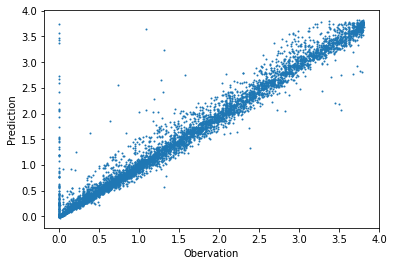

In [52]:
plt.scatter(df_pred['true'], df_pred['pred'], s=1)

plt.xlabel('Obervation')
plt.ylabel('Prediction')

##### Anomalous data points in PV data

The PV data shows a number of points where the observed value is 0 but the prediction is much higher. 

First let's try and identify them (setting the tolerance to be lower will capture more values as anomalous). 

(array([ 3.,  5., 13., 11., 18., 12., 16.,  7.,  5.,  3.]),
 array([ 6.  ,  7.25,  8.5 ,  9.75, 11.  , 12.25, 13.5 , 14.75, 16.  ,
        17.25, 18.5 ]),
 <BarContainer object of 10 artists>)

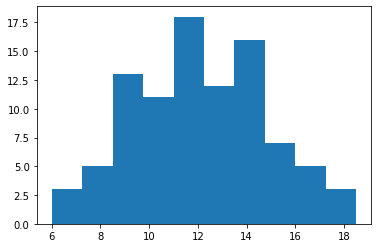

In [53]:
def identify_anomalies_pv(df_pred, tolerance=0.1):
    foo = df_pred.copy()
    foo['difference'] = foo.pred - foo.true
    foo = foo[(foo.difference > tolerance) & (foo.true == 0)]
    return foo.index

anomalous_dates = dates[identify_anomalies_pv(df_pred)]
anomalous_df = df_power_features[df_power_features.index.isin(anomalous_dates)]
plt.hist(anomalous_df.hour) # Check this histogram to eyeball if any unreasonable anomalous values are caught by the tolerance (e.g. late at night)

Replace these values in `df_power_features`. 

In [54]:
df_power_features_clean = df_power_features.copy()
df_power_features_clean.loc[df_power_features_clean.index.isin(anomalous_dates), 'pv_power_mw'] = np.nan

Rerun the previous model fitting and check the pred vs. actual graph. 

Text(0, 0.5, 'Prediction')

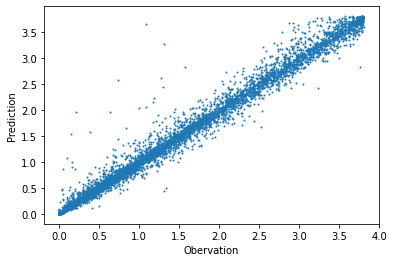

In [55]:
models = {
    'std_linear': LinearRegression(),
    'random_forest': RandomForestRegressor(),
    'boosted': GradientBoostingRegressor()
}

rerun_site_power_model = False
model_scores_filename = 'site_power_interp_clean_model_results.csv'

X, y, dates = split_X_y_data_with_index(df_power_features_clean, 'pv_power_mw')

if (rerun_site_power_model == True) or (model_scores_filename not in os.listdir(cache_data_dir)):
    df_model_scores = evaluate_models(X, y, models)
    df_model_scores.to_csv(f'{cache_data_dir}/{model_scores_filename}')
else:
    df_model_scores = pd.read_csv(f'{cache_data_dir}/{model_scores_filename}', index_col='metric')

top_model = df_model_scores.T['rmse'].idxmin()
df_pred = generate_kfold_preds(X, y, models[top_model])

plt.scatter(df_pred['true'], df_pred['pred'], s=1)

plt.xlabel('Obervation')
plt.ylabel('Prediction')

The above graph looks to be a cleaner with tolerance at 0.1. It looks like there might still be some which aren't though. Consider lowering the tolerance.

In [56]:
#exports
def pv_anomalies_to_nan(df_pv, model=GradientBoostingRegressor(), tolerance=0.1):
    """
    Run this function to identify places where predicted values for pv_power_mw are much larger
    than true values and where the true value is 0 (we expect these are anomalies) and make these values nan.

    """
    df_power_features = construct_df_power_features(df_pv)
    
    X, y, dates = split_X_y_data_with_index(df_power_features, 'pv_power_mw')
    df_pred = generate_kfold_preds(X, y, model)
    df_pred['difference'] = df_pred.pred - df_pred.true
    df_pred['datetime'] = dates
    df_pred = df_pred.set_index('datetime')
    
    anomalous_idx = df_pred[(df_pred.difference > tolerance) & (df_pred.true == 0)].index    
    
    df_pv.loc[df_pv.index.isin(anomalous_idx), 'pv_power_mw'] = np.nan
        
    return df_pv

In [57]:
df_pv = pv_anomalies_to_nan(df_pv)

In [58]:
#exports
def interpolate_missing_site_power(df_pv, model=RandomForestRegressor()):
    missing_site_power_dts = df_pv.index[df_pv['pv_power_mw'].isnull()]
    
    if len(missing_site_power_dts) == 0: # i.e. no missing values
        return df_pv

    df_power_features = construct_df_power_features(df_pv)
    missing_dt_X = df_power_features.loc[missing_site_power_dts].drop('pv_power_mw', axis=1).values
    X, y = split_X_y_data(df_power_features, 'pv_power_mw')
 
    model.fit(X, y)
    df_pv.loc[missing_site_power_dts, 'pv_power_mw'] = model.predict(missing_dt_X)
    
    assert df_pv['pv_power_mw'].isnull().sum() == 0, 'There are still null values for the solar site power'
    
    return df_pv

In [59]:
df_pv = interpolate_missing_site_power(df_pv)

df_pv.isnull().mean()

irradiance_Wm-2    0.0
panel_temp_C       0.0
pv_power_mw        0.0
dtype: float64

In [60]:
#exports
def interpolate_missing_weather_solar(df_pv, df_weather, weather_col='solar_location2', model=RandomForestRegressor()):
    missing_weather_solar_dts = df_weather.index[df_weather[weather_col].isnull()]
    
    if len(missing_weather_solar_dts) == 0: # i.e. no missing values
        return df_pv

    df_irradiance_features = construct_df_irradiance_features(df_weather, df_pv).drop('site_solar', axis=1)
    missing_dt_X = df_irradiance_features.loc[missing_weather_solar_dts].drop(weather_col, axis=1).values
    X, y = split_X_y_data(df_irradiance_features, weather_col)
 
    model.fit(X, y)
    df_weather.loc[missing_weather_solar_dts, weather_col] = model.predict(missing_dt_X)
    
    assert df_weather[weather_col].isnull().sum() == 0, 'There are still null values for the weather dataset solar observations'
    
    return df_weather

In [61]:
df_weather = interpolate_missing_weather_solar(df_pv, df_weather)

df_weather.isnull().mean()

solar_location1    0.0
solar_location2    0.0
solar_location3    0.0
solar_location4    0.0
solar_location5    0.0
solar_location6    0.0
temp_location1     0.0
temp_location2     0.0
temp_location3     0.0
temp_location4     0.0
temp_location5     0.0
temp_location6     0.0
dtype: float64

<br>

Finally we'll export the relevant code to our `batopt` module

In [62]:
#hide
from nbdev.export import notebook2script
    
notebook2script()

Converted 00-utilities.ipynb.
Converted 01-retrieval.ipynb.
Converted 02-cleaning.ipynb.
Converted 03-charging.ipynb.
Converted 04-discharging.ipynb.
Converted 05-constraints.ipynb.
Converted 06-tuning.ipynb.
Converted 07-charging-nn.ipynb.
Converted 08-pipeline.ipynb.
